In [4]:
import os
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from torch.utils.data import WeightedRandomSampler
import torch
import torch.nn as nn
import timm
import torch.optim as optim
from torchvision import models
from torchvision.models import vit_b_16, ViT_B_16_Weights, convnext_small, ConvNeXt_Small_Weights
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

In [2]:
data_dir = "HyperKvasirDataset"

In [3]:
all_data = ImageFolder(root=data_dir)

In [5]:
# Stratified split of dataset due to large class imbalance
labels = np.array([all_data.targets[i] for i in range(len(all_data))])

# 70% train, 20% val, 10% test
train_idx, temp_idx, train_labels, temp_labels = train_test_split(
    np.arange(len(all_data)), labels, test_size=0.3, stratify=labels, random_state=42
)

val_idx, test_idx, val_labels, test_labels = train_test_split(
    temp_idx, temp_labels, test_size=0.33, stratify=temp_labels, random_state=42
)

In [6]:
# Create the data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = val_transform

In [7]:
# Create Subsets
train_dataset = Subset(all_data, train_idx)
val_dataset = Subset(all_data, val_idx)
test_dataset = Subset(all_data, test_idx)

# Set the augmentations
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = test_transform

In [8]:
# Compute class weights for use with weighted loss function and WeightedRandomSampler
class_counts = np.bincount(train_labels)
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
print(class_counts, class_weights)

[ 29  37 452 804 706 701 692 282 182   4   6  92 720 699 274 535  24 141
   8 310  20  93 652] tensor([0.0345, 0.0270, 0.0022, 0.0012, 0.0014, 0.0014, 0.0014, 0.0035, 0.0055,
        0.2500, 0.1667, 0.0109, 0.0014, 0.0014, 0.0036, 0.0019, 0.0417, 0.0071,
        0.1250, 0.0032, 0.0500, 0.0108, 0.0015])


In [9]:
# Create WeightedRandomSampler for oversampling minority classes in training batches
sample_weights = class_weights[train_labels]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_labels), replacement=True)

In [10]:
# Get the pretrained models
def GetDesiredModel(model_name):
    num_classes = len(list(all_data.class_to_idx.keys()))

    if model_name == "VIT":
        model = models.vit_b_16(weights=ViT_B_16_Weights.DEFAULT)

        # Freeze base parameters
        for param in model.parameters():
            param.requires_grad = False

        # Replace the classifier head and add dropout layer
        model.heads.head = nn.Sequential(
                nn.Linear(model.heads.head.in_features, 512),  # Fully connected layer
                nn.ReLU(),
                nn.Dropout(p=0.4),  # Apply dropout
                nn.Linear(512, num_classes)  # Final classification layer
        )

        # Unfreeze the new classification head
        for param in model.heads.head.parameters():
            param.requires_grad = True
            
    elif model_name == "ConvNext":
        model = models.convnext_small(weights=ConvNeXt_Small_Weights.DEFAULT)
    
        # Freeze base parameters
        for param in model.parameters():
            param.requires_grad = False

        # Replace the classifier head
        model.classifier[2] = nn.Sequential(
            nn.Linear(model.classifier[2].in_features, 512),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(512, num_classes)
        )
    
        # Unfreeze the new classification head
        for param in model.classifier[2].parameters():
            param.requires_grad = True

    else:
        raise ValueError("Invalid model name, choose VIT or ConvNext")

    return model

In [11]:
# Learning rate warmup function
def warmup_lr(epoch, warmup_epochs=3):
    if epoch < warmup_epochs:
        val = (epoch+1) / warmup_epochs
        return val # Gradually increase LR

    return 1.0 # Keep LR at base value after warmup

In [17]:
# Get pretrained model
model_type = "ConvNext"
model = GetDesiredModel(model_type)

# Define hyperparameters
batch = 64
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
learning_rate = 0.001
decay = 0.01
lr_warmup_epochs = 3
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=decay)
num_epochs = 20

# Divide the learning rate in half if there are three consecutive epochs of decreasing validation performance
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
# Add a learning rate scheduler to gradually increase the learning rate the first few epochs
warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: warmup_lr(epoch, lr_warmup_epochs))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False)

In [18]:
# Evaluate models based on F1 score
best_val_f1 = -1.0
best_val_path = f"{model_type}_best_model.pth"

# Accumulate gradients for 2 training batches
gradient_accumulation_steps = 2

all_training_f1 = []
all_validation_f1 = []

for epoch in range(num_epochs):    
    print(f"\nEpoch {epoch+1}: Learning Rate: {optimizer.param_groups[0]['lr']}")

    model.train()
    train_loss = 0
    all_train_preds = []
    all_train_labels = []
    optimizer.zero_grad() # Clear gradients at start of epoch

    # Training loop
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Accumulate loss before scaling
        train_loss += loss.item()

        # Get predictions
        preds = torch.argmax(outputs, dim=1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

        # Scale loss for gradient accumulation
        loss /= gradient_accumulation_steps
        # Backprop
        loss.backward() 
        
        # Update weights every predefined interval
        if (i + 1) % gradient_accumulation_steps == 0 or (i + 1) == len(train_loader):
            optimizer.step()
            optimizer.zero_grad()

    # Get train loss and F1 score
    train_loss /= len(train_loader)
    train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')
    all_training_f1.append(train_f1)

    # Adjust learning rate initially
    if epoch < lr_warmup_epochs:
        warmup_scheduler.step()
    
    # Validation loop
    model.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Get predictions
            preds = torch.argmax(outputs, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    # Calculate the loss and F1 score
    val_loss /= len(val_loader)
    val_f1 = f1_score(all_val_labels, all_val_preds, average='macro')
    all_validation_f1.append(val_f1)
    
    # Adjust learning rate based on validation loss
    scheduler.step(val_loss)

    print(f"Train Loss: {train_loss:.4f} | Training F1 Score: {train_f1:.4f}")
    print(f"Validation Loss: {val_loss:.4f} | Validation F1 Score: {val_f1:.4f}")

    # Save the best model based on validation loss
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        print("New best model saved.")
        torch.save(model.state_dict(), best_val_path)


Epoch 1: Learning Rate: 0.0003333333333333333
Train Loss: 1.1832 | Training F1 Score: 0.0931
Validation Loss: 3.8041 | Validation F1 Score: 0.0155
New best model saved.

Epoch 2: Learning Rate: 0.0006666666666666666
Train Loss: 0.4434 | Training F1 Score: 0.1939
Validation Loss: 2.1895 | Validation F1 Score: 0.1189
New best model saved.

Epoch 3: Learning Rate: 0.001
Train Loss: 0.2716 | Training F1 Score: 0.4311
Validation Loss: 1.4925 | Validation F1 Score: 0.3478
New best model saved.

Epoch 4: Learning Rate: 0.001
Train Loss: 0.1863 | Training F1 Score: 0.5810
Validation Loss: 1.4572 | Validation F1 Score: 0.3868
New best model saved.

Epoch 5: Learning Rate: 0.001
Train Loss: 0.1586 | Training F1 Score: 0.6539
Validation Loss: 1.2786 | Validation F1 Score: 0.4606
New best model saved.

Epoch 6: Learning Rate: 0.001
Train Loss: 0.1331 | Training F1 Score: 0.7002
Validation Loss: 1.2848 | Validation F1 Score: 0.4815
New best model saved.

Epoch 7: Learning Rate: 0.001
Train Loss: 0

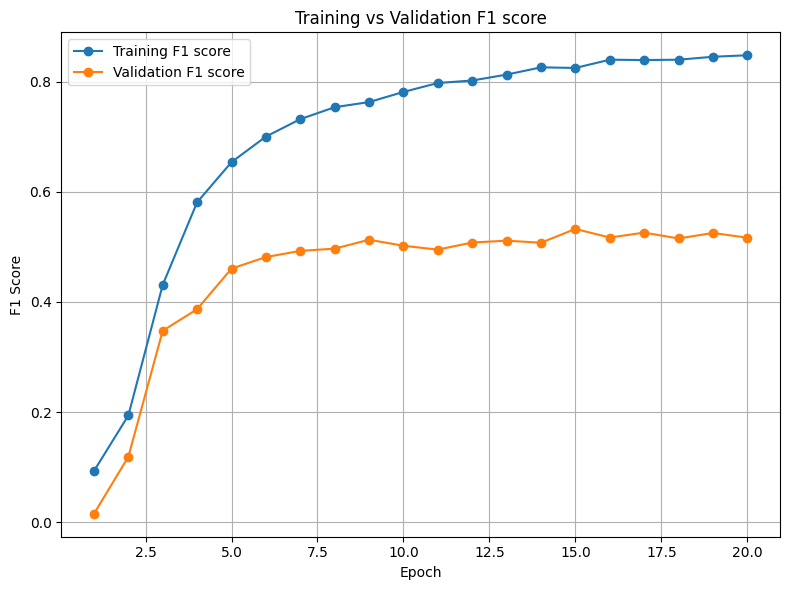

In [20]:
# Plot the loss and F1 score vs training epoch
epochs = range(1, len(all_training_f1) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, all_training_f1, label='Training F1 score', marker='o')
plt.plot(epochs, all_validation_f1, label='Validation F1 score', marker='o')
plt.title('Training vs Validation F1 score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# Best validation F1 scores from the above training/validation loop
vit_f1 = 0.5624
convnext_f1 = 0.5326

# Compute weights normalized by sum of F1 scores
vit_weight = vit_f1 / (vit_f1 + convnext_f1)
convnext_weight = convnext_f1 / (vit_f1 + convnext_f1)

In [22]:
# Load the best performing vit16 and convnext models
model_type = "ConvNext"
best_val_path = f"{model_type}_best_model.pth"
conv_next_model = GetDesiredModel(model_type)
conv_next_model.load_state_dict(torch.load(best_val_path, weights_only=True))
conv_next_model.eval()

model_type = "VIT"
best_val_path = f"{model_type}_best_model.pth"
vit16_model = GetDesiredModel(model_type)
vit16_model.load_state_dict(torch.load(best_val_path, weights_only=True))
vit16_model.eval()

all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass for logits from both bodels
        conv_next_outputs = conv_next_model(images)
        vit16_outputs = vit16_model(images)

        # Convert logits to probabilities using softmax
        conv_next_probs = torch.softmax(conv_next_outputs, dim=1)
        vit16_probs = torch.softmax(vit16_outputs, dim=1)

        # Compute weighted average of probabilities
        ensemble_probs = (convnext_weight * conv_next_probs) + (vit_weight * vit16_probs)

        # Get final class predictions based on highest probability
        preds = torch.argmax(ensemble_probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [23]:
# Compute evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

# Get class names from ImageFolder
class_names = list(all_data.class_to_idx.keys())  # Ensures all classes are included

# Generate classification report
class_report = classification_report(all_labels, all_preds, zero_division=0, target_names=class_names)

# Print results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# Print per-class results
print("\nPer-Class Metrics:")
print(class_report)

Test Accuracy: 0.8210
Test Precision: 0.5631
Test Recall: 0.6126
Test F1 Score: 0.5655

Per-Class Metrics:
                              precision    recall  f1-score   support

                    barretts       0.08      0.25      0.12         4
      barretts-short-segment       0.10      0.40      0.15         5
                    bbps-0-1       0.98      0.97      0.98        64
                    bbps-2-3       1.00      0.84      0.91       113
                       cecum       0.98      0.96      0.97       100
          dyed-lifted-polyps       0.88      0.85      0.87        99
      dyed-resection-margins       0.87      0.88      0.87        98
               esophagitis-a       0.36      0.45      0.40        40
             esophagitis-b-d       0.65      0.77      0.70        26
                 hemorrhoids       0.00      0.00      0.00         1
                       ileum       0.00      0.00      0.00         1
              impacted-stool       0.43      1.00   